In [1]:
dt_file =  '/data/dt/'
out_file = 'result/scorecard/'

In [3]:
import pandas as pd
import numpy as np
import re
import copy
import warnings
warnings.filterwarnings('ignore')
import riskModel as rs
import scorecardpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18 #字体大小
plt.rcParams['font.family'] = ['Arial Unicode MS'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
%matplotlib inline

In [4]:
# 加载数据
data = pd.read_csv(dt_file+'data_dfs.csv')
data.sample(3)

,C_APP_ID,APP_CHANNEL,id_number,name,mobile,apply_date,LOAN_DATE,FINANCE_PRODUCT_CODE,TENOR,OVERDUE_DAYS,...,br.按手机号查询，近12个月申请线下消费分期的次数 / br.按身份证号查询，近6个月在非银机构申请机构数,br.按身份证号查询，近3个月在非银机构申请最大间隔天数,br.按手机号查询，近12个月申请线上现金分期的次数 / br.按身份证号查询，近3个月在非银机构-持牌消费金融机构申请机构数,br.按手机号查询，近12个月申请线上现金分期的次数 / br.按手机号查询，近1个月在非银机构-持牌网络小贷机构申请机构数,br.按身份证号查询，近3个月在非银机构-消费类分期机构申请次数 / br.按手机号查询，近12个月申请线上现金分期的次数,br.按手机号查询，近12个月申请线上现金分期的次数 / br.按手机号查询，近12个月在非银机构-持牌网络小贷机构申请机构数,br.按手机号查询，近12个月申请线下消费分期的次数 / br.按手机号查询，近12个月在非银机构-持牌消费金融机构申请机构数,br.按身份证号查询，近12个月最大月申请次数,br.按身份证号查询，近3个月申请线上现金分期的次数 / br.按手机号查询，近3个月在非银机构-持牌网络小贷机构申请机构数,br.按身份证号查询，近3个月申请线上小额现金贷的次数 / br.按手机号查询，近12个月申请线下消费分期的次数
11621,2494420734205959,BEIBEI01,437de10a0e13515ab0fd4fe36bf9b983,3a0a8b7c86f7b1652d953146ad0c363d,99510c3cfc609cf5f6bcabc28bcfef19,2020-06-28,2020-06-28,PDL02,12,0,...,NaN,28.0,14.0,14.0,0.357143,2.333333,NaN,14.0,1.000000,NaN
10713,2428763788394550,RONGSHU,00287e023362fa72b79565a2453d2898,c9fb0991d1c6904f33c2d8e9d8b67ec4,9fd563d6589b2cc02f55ff567b9325f0,2020-03-27,2020-03-27,PDL02,12,322,...,1.00,30.0,8.0,8.0,0.375000,1.333333,1.571429,15.0,0.333333,0.363636
13422,2422776115544140,RONGSHU,e555741975c546fa499ba68e77f70aea,0225d66ab09afe56cddd1414ff2b17e0,16fa14ea68ad2311fdfb8967a383b971,2020-03-19,2020-03-19,PDL02,12,300,...,0.25,25.0,1.0,1.0,2.000000,1.000000,0.500000,2.0,1.000000,1.000000


In [5]:
# 加载特征
with open(dt_file+'features_dfs.txt','r') as f:
    features = f.read().split('\n')
    features = [f for f in features if f]
    
with open(dt_file+'cat_feature_new.txt','r') as f:
    cat_features = f.read().split('\n')
    cat_features = [f for f  in cat_features if f]

self_drop = ['mob.fraud_stage'
            ]

features = [i for i in features if i not in self_drop]
cat_features = [i for i in cat_features if i not in self_drop and i in features]
print(len(features))
print(cat_features)

128
[]


In [6]:
# 极值处理,缺失处理
data = data.replace({float('inf'):-998,float('-inf'):-998})
# 缺失填充
pr = rs.Preprocess()
data = pr.fill_nan(df=data,cols=features,values=-999,min_miss_rate=0.05)

In [7]:
# 数据集划分
# 分层抽样, 每个月随机抽取30%
# 随机抽样, 抽取 30%做验证

from datetime import datetime
from sklearn.model_selection import train_test_split

dt = copy.deepcopy(data)
dt = dt.loc[(dt['target'] != -999)&(dt['target'] != 2),:]

sample_method = 1 # 1-按日分层, 2-按月分层, 3-按日期切, 4-全量样本 

test_size = 0.3 
if sample_method == 1:
    train,valid = train_test_split(dt,test_size=test_size,random_state=45,stratify=dt[['apply_date']])
elif sample_method == 2:
    dt['mon'] = dt['apply_date'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d').month)
    train,valid = train_test_split(dt,test_size=test_size,random_state=45,stratify=dt[['mon','target']])
elif sample_method == 3:
    train = dt.loc[dt['apply_date'] <  datetime.strptime('20200501','%Y%m%d'),:]
    valid = dt.loc[dt['apply_date'] >= datetime.strptime('20200501','%Y%m%d'),:]
elif sample_method == 4:
    train = copy.deepcopy(dt)
    valid = copy.deepcopy(dt)
else: # 随机抽样
    train,valid = train_test_split(dt,test_size=test_size,random_state=45)
    
print('train size:',train.shape)
print('valid size:',valid.shape)
print('train:\n',train['target'].value_counts(normalize=False))
print('test:\n',valid['target'].value_counts(normalize=False))

train size: (9128, 145)
valid size: (3913, 145)
train:
 0    8028
1    1100
Name: target, dtype: int64
test:
 0    3452
1     461
Name: target, dtype: int64


In [8]:
# cat_bin,cat_iv = rs.cat_bin(df=dt,
#                             cols=cat_features,target='target_s2',specials=['-999'],
#                             bin_num_limit=5,count_distr_limit=0.05,method='chimerge')
# cat_iv

In [9]:
# num_features

In [10]:
# train.reset_index(drop=True,inplace=True)

In [11]:
num_features = [i for i in features if i not in cat_features]
non_mono_cols = [i for i in num_features if  bool(re.search('br\.|td\.|zzc\.',i)) and not bool(re.search('评分|融分|通用分',i))]

error_bin,drop_col = [],[]
num_bin,num_iv = {},{}
for i,col in enumerate(num_features):
    if i%200 == 0:
        print(i)
    try:
        bin1,iv1 = rs.num_bin(df=train,
                                cols=[col],
                                target='target',
                                specials=[-999,-998],
                                bin_num_limit=8,
                                count_distr_limit=0.05,
                                sc_method='chimerge',
                                non_mono_cols=non_mono_cols,
                                init_bins=15,
                                init_min_samples=0.05,
                                init_method='chi')
        num_bin.update(bin1)
        num_iv.update(iv1)
    except Exception as e:
        print(col,str(e))
        error_bin.append(col)
        try:
            bin1 = sc.woebin(train,y='target',x=col,special_values=[-998,-999])
            iv1 = {col:bin1[col]['total_iv'].unique()[0]}
            num_bin.update(bin1)
            num_iv.update(iv1)
        except Exception as e:
            print(col,str(e))
            drop_col.append(col)

In [13]:
drop_col

In [14]:
num_features = list(set(num_features)-set(drop_col))
features = list(set(num_features)-set(drop_col))

In [15]:
# 自定义分箱
self_bin = {
    'mob.credit_score':[600,725],
    'mob.wd_score_v1':[600,713,735],
    'mob.wd_score_v2':[572,693],
    'td.zrf.通用分标准版_':[570,680],
    'br.信用风险识别-线上现金分期':[530,620,690],
    'br.按身份证号查询，近3个月申请线上现金分期的次数 / br.按手机号查询，近3个月在非银机构-持牌网络小贷机构申请机构数':[2,3],
    'br.按手机号查询，近12个月申请线上现金分期的次数 / br.按身份证号查询，近6个月在非银机构-持牌网络小贷机构申请次数':[1,3],
    'zzc.D540.身份证号码.贷款类型列表_len':[12,20,30,38],
    'br.按身份证号查询，近12个月在非银机构-持牌小贷机构申请次数 / br.按身份证号查询，近6个月在非银机构申请机构数':[0.4,1],
    'br.按身份证号查询，近3个月在非银机构-持牌消费金融机构申请机构数 / br.按手机号查询，近12个月申请线上现金分期的次数':[0.1,0.4],
    'br.按手机号查询，近3个月在非银机构-消费类分期申请机构数 / br.按手机号查询，近12个月申请线下消费分期的次数':[1,2],
    'zzc.D90.身份证号码.贷款类型列表_len':[8,12,18],
    'br.按手机号查询，近3个月在非银机构-消费类分期申请机构数 / br.按手机号查询，近12个月有申请记录月份数':[0.2,0.3],
    'br.按身份证号查询，近3个月在非银机构-消费类分期机构申请次数 / br.按手机号查询，近12个月申请线上现金分期的次数':[0.4,0.9],
    'br.按手机号查询，近6个月申请线下现金分期的机构数 / br.按手机号查询，近12个月有申请记录月份数':[0.1,0.2],
    'br.按身份证号查询，近12个月申请线上小额现金贷的次数':[3,9,13],
    'br.按身份证号查询，近12个月在非银机构周末申请次数 / br.按手机号查询，近15天在非银机构-消费类分期机构申请次数':[3],
    'br.按手机号查询，近6个月申请线上小额现金贷的机构数':[3,4],
    
}

for col,value in self_bin.items():
    num_bin.update(sc.woebin(dt=train,y='target',x=col,breaks_list={col:value},special_values=[-999,-998]))
    num_iv.update({col:num_bin[col]['total_iv'].unique()[0]})

In [16]:
col =  list(high_iv.keys())[76].replace('_woe','')
print(f"{col,round(num_iv[col],2)}")
a = num_bin[col][['bin','count_distr','badprob']]
a[['count_distr','badprob']] = (a[['count_distr','badprob']]*100).astype('int')
a

In [18]:
cat_bin,cat_iv = {},{}
bins = {**cat_bin,**num_bin}
ivs = {**cat_iv,**num_iv}

In [19]:
# woe转换
train_woe = sc.woebin_ply(dt=train,bins=bins)
valid_woe = sc.woebin_ply(dt=valid,bins=bins)
data_woe = sc.woebin_ply(dt=data,bins=bins)

In [20]:
# 缺失检查
f = [i+'_woe' for i in bins.keys()]
print(f'train: {train_woe[f].isnull().sum().any()}')
print(f'valid: {valid_woe[f].isnull().sum().any()}')
print(f'data: {data_woe[f].isnull().sum().any()}')

In [588]:
#########################################
# 3.特征选择
#########################################
sf = rs.SelectFeature()
high_iv = sf.baseOn_iv(ivd=ivs,thred=0.02,is_draw=False)
len(high_iv)

70

In [589]:
# 保存high_iv
import joblib
_ = joblib.dump(high_iv,out_file+'high_iv.pkl')

In [728]:
low_vif = sf.baseOn_collinear(df=train_woe,high_iv=high_iv,thred=0.7,is_draw=False)

In [591]:
def plot_bins(key:int=0,col=None):
    # 变量选择
    if not col:
        col = list(low_vif.keys())[key].replace('_woe','')
    col = col.replace('_woe','')
    print({col:bins[col]['total_iv'].unique()[0]})
    plt_df = copy.deepcopy(bins[col])
    try:
        plt_df.set_index(keys='bin',inplace=True)
    except:
        pass
    fig = plt.figure(figsize=(14,7))
    ax1 = fig.add_subplot(111)
    plt_df['badprob'].plot(ax=ax1,kind = 'line', style='rD-',label='坏样本占比',grid=False,mark_right=True,fontsize=15)
    plt_df['count_distr'].plot(ax=ax1,kind = 'bar',label='样本占比',grid=False,mark_right=True,fontsize=15)    
    
    plt.xlabel('分组')             
    ax1.set_yticks(np.arange(0.01,0.7,0.05))        # 设置左边纵坐标刻度
    ax1.set_ylabel('百分比')                  # 设置左边纵坐标标签
    plt.legend(loc=2)                 # 设置图例在左上方

    ax2 = ax1.twinx()
    plt_df['woe'].plot(ax=ax2,kind = 'line', style='mD-.',label='WOE',grid=True,fontsize=15)
    ax2.set_yticks(np.arange(min(plt_df['woe'])-0.1,max(plt_df['woe'])+0.1,0.5))    # 设置右边纵坐标刻度
    ax2.set_ylabel('woe')       # 设置右边纵坐标标签
    plt.legend(loc=1)           # 设置图例在右上方
    plt.title(f'{col}')         # 给整张图命名
    plt.show()

In [623]:
# 手动删除特征
self_drop = [#'mob.credit_score','mob.wd_score_v1','mob.wd_score_v2',
             'td.dqsh.身份证关联到的180天内P2P网贷行业下贷款事件中的不同平台个数 / td.dqsh.身份证关联到的270天内非银行类金融行业下申贷事件中近90日的新增平台数',
             'br.按手机号查询，近3个月在非银机构-消费类分期申请机构数 / br.按身份证号查询，近6个月在非银机构有申请记录月份数',
             'br.按手机号查询，近12个月申请线下消费分期的次数 / br.按身份证号查询，近12个月在非银机构-消费类分期申请机构数',
             'br.按手机号查询，近1个月在非银机构-消费类分期申请机构数 / br.按身份证号查询，近12个月在非银机构-持牌网络小贷机构申请次数',
             'br.按手机号查询，近1个月在非银机构-消费类分期申请机构数 / br.按手机号查询，近3个月在非银机构-消费类分期申请机构数',
             'br.按身份证号查询，近6个月在非银机构-持牌小贷机构申请机构数 / br.按手机号查询，近3个月在非银机构-消费类分期申请机构数',
             'zzc.D720.身份证号码.其他类.申请数',
             'br.按手机号查询，近12个月申请线上小额现金贷的机构数',
             'td.dqsh.身份证关联到的180天内非银行类金融行业下申贷事件中30日平台数的标准差',
             'br.按身份证号查询，近12个月在非银机构-持牌消费金融机构申请次数 / br.按手机号查询，近12个月申请线下消费分期的次数',
             'br.按手机号查询，近15天在非银机构-消费类分期机构申请次数 / br.按身份证号查询，近12个月在非银机构-消费类分期申请机构数',
             'br.按身份证号查询，近3个月申请线上现金分期的次数 / br.按手机号查询，近1个月在非银机构-持牌网络小贷机构申请机构数',
             'br.按手机号查询，近1个月在非银机构-持牌消费金融机构申请次数 / br.按手机号查询，近6个月申请线下现金分期的次数',
             'br.按身份证号查询，近12个月在非银机构-消费类分期申请机构数 / br.按手机号查询，近12个月在非银机构-改制机构申请次数',
             'td.zrf.小额多期分标准版_',
            'br.按身份证号查询，近6个月在非银机构-持牌网络小贷机构申请次数 / br.按手机号查询，近12个月申请线上现金分期的次数',
            'td.zrf.智融分2.0银行分标准版',
            'br.按身份证号查询，近12个月在非银机构平均每月申请次数(有申请月份平均) / br.按手机号查询，近3个月在非银机构-持牌网络小贷机构申请机构数',
            'br.按手机号查询，近12个月申请线下消费分期的次数 / br.按手机号查询，近12个月在非银机构-持牌消费金融机构申请机构数',
            'br.按手机号查询，近1个月在非银机构-持牌网络小贷机构申请机构数 / br.按身份证号查询，近3个月申请线上现金分期的次数',
            'br.按身份证号查询，近12个月在非银机构平均每月申请次数(有申请月份平均) / br.按手机号查询，近1个月在非银机构-持牌网络小贷机构申请机构数',
            'br.按手机号查询，近3个月在非银机构-消费类分期申请机构数 / br.按身份证号查询，近12个月有申请记录月份数',
            'zzc.D360.身份证号码.非银行持牌类.申请数 / zzc.D720.手机号码.非银行持牌类.申请数',
            'br.按手机号查询，近12个月在非银机构-持牌网络小贷机构申请机构数',
            'br.按手机号查询，近12个月申请线下消费分期的次数 / br.按身份证号查询，近3个月在非银机构-持牌消费金融机构申请机构数',
            'zzc.D360.身份证号码.其他类.申请数',
            'br.按身份证号查询，近6个月在非银机构-持牌网络小贷机构申请次数 / br.按手机号查询，近15天在非银机构周末申请机构数',
            'br.按手机号查询，近6个月申请线下现金分期的机构数 / br.按身份证号查询，近12个月有申请记录月份数',
            'td.dqsh.身份证关联到的90天内全行业下贷款事件中的不同平台个数',
            'br.线下消费贷客群评分',
            'br.按身份证号查询，近6个月在非银机构-持牌网络小贷机构申请次数 / br.按手机号查询，近12个月申请线上现金分期的次数',
            'zzc.D360.身份证号码.非银行持牌类.申请数 / zzc.D720.手机号码.非银行持牌类.申请数',
            'br.按手机号查询，近3个月在非银机构-消费类分期申请机构数 / br.按身份证号查询，近6个月在非银机构有申请记录月份数',
            'zzc.D720.身份证号码.其他类.申请机构数',
            'br.按手机号查询，近15天在非银机构-消费类分期机构申请次数 / br.按身份证号查询，近12个月在非银机构周末申请次数',
            'br.按身份证号查询，近6个月在非银机构-持牌网络小贷机构申请次数 / br.按手机号查询，近12个月申请线上现金分期的次数',
            'br.按身份证号查询，近3个月在非银机构-持牌消费金融机构申请机构数 / br.按手机号查询，近12个月申请线下消费分期的次数',
            ]


In [593]:
len(low_vif)

49

In [594]:
bins[list(low_vif_new.keys())[0].replace('_woe','')]

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,mob.credit_score,"[-inf,600.0)",1382,0.105973,1004,378,0.273517,1.018427,0.157547,0.311652,600.0,False
1,mob.credit_score,"[600.0,725.0)",7468,0.572655,6526,942,0.126138,0.059736,0.002090,0.311652,725.0,False
2,mob.credit_score,"[725.0,inf)",4191,0.321371,3950,241,0.057504,-0.801394,0.152015,0.311652,inf,False


{'YM_SCORE': 0.04330420227030932}


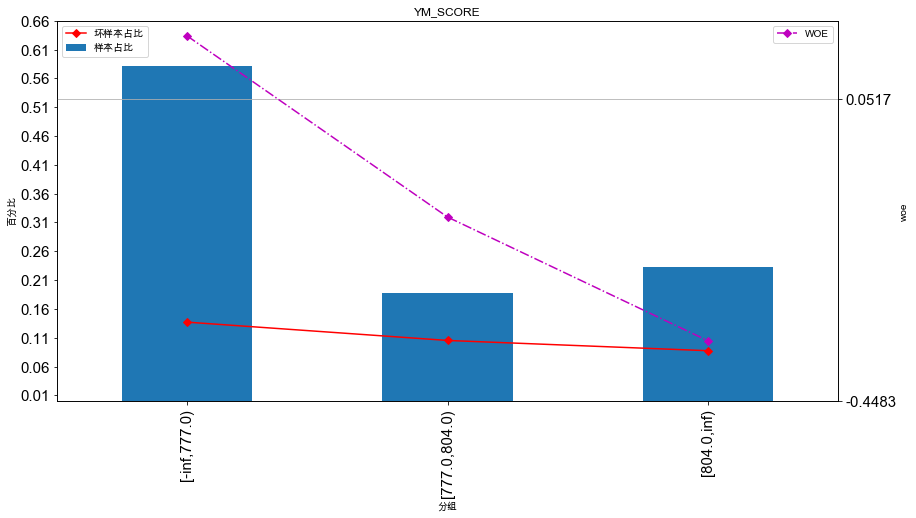

In [638]:
plot_bins(col=list(ml_features_new.keys())[7])

In [624]:
low_vif_new = {k:high_iv[k] for k in low_vif.keys() if k.replace('_woe','') not in self_drop}
len(low_vif_new)

36

In [629]:
ml_features, best_C = sf.baseOn_l1(X=train_woe[low_vif_new.keys()],y=train_woe['target'],
                                   Kfold=3,drop_plus=False)
ml_features = {k[0]:k[1] for k in 
               sorted({k:high_iv[k] for k in ml_features.keys()}.items(),
                      key=lambda x:x[1],
                      reverse=True
                     )
              }
ml_features

best_scoring:0.702
best_params:{'C': 0.11}


{'mob.credit_score_woe': 0.3116520532310414,
 'mob.wd_score_v2_woe': 0.29891447437067586,
 'mob.wd_score_v1_woe': 0.2834497551478068,
 'td.zrf.智融分2.0通用分标准版_woe': 0.07484053667529829,
 'td.zrf.智融分2.0非银分标准版_woe': 0.07226985484709622,
 'br.按手机号查询，近12个月在非银机构-持牌网络小贷机构申请机构数 / br.按手机号查询，近12个月申请线上现金分期的次数_woe': 0.04914835932395261,
 'br.按手机号查询，近12个月申请线上现金分期的次数 / br.按身份证号查询，近6个月在非银机构申请机构数_woe': 0.04639366709705974,
 'YM_SCORE_woe': 0.04330420227030932,
 'br.按身份证号查询，近3个月申请线上现金分期的次数 / br.按手机号查询，近3个月在非银机构-持牌网络小贷机构申请机构数_woe': 0.03559535691528057,
 'br.按身份证号查询，近12个月在非银机构-持牌小贷机构申请次数 / br.按手机号查询，近3个月在非银机构-持牌网络小贷机构申请机构数_woe': 0.03327425705139257,
 'br.信用风险识别-线上现金分期_woe': 0.03237190928666846,
 'td.dqsh.身份证关联到的270天内非银行类金融行业下申贷事件中近90日的新增平台数_woe': 0.03187206502720753,
 'td.zrf.通用分标准版__woe': 0.030822127902957894,
 'br.按手机号查询，近12个月申请线上现金分期的次数 / br.按身份证号查询，近3个月在非银机构-持牌消费金融机构申请机构数_woe': 0.030627901430540824,
 'br.按手机号查询，近12个月申请线下消费分期的次数 / br.按身份证号查询，近3个月在非银机构-消费类分期机构申请次数_woe': 0.030616713976658414,
 'br.按身份证号查询

In [630]:
ml_features_new = {k:v for k,v in ml_features.items() if v >= 0.03}
len(ml_features_new)

15

training model result:
{'AUC': 0.7074604226117679, 'KS': 0.30484440820763686, 'cut_prob': 0.5120655230198412, 'recall': 0.6036363636363636, 'precision': 0.21628664495114006, 'accuracy': 0.6886503067484663, 'f1': 0.3184652278177458}


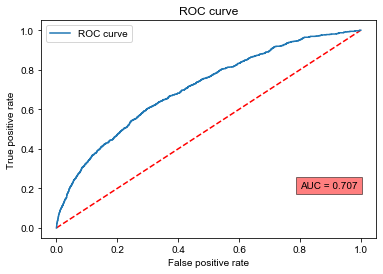

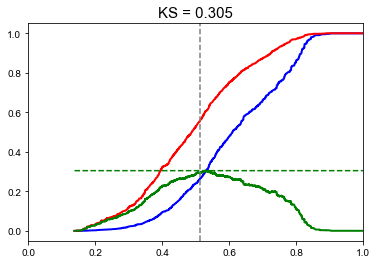

model params:
mob.credit_score_woe                                                        0.537318
mob.wd_score_v2_woe                                                         0.407716
mob.wd_score_v1_woe                                                         0.362686
td.zrf.智融分2.0通用分标准版_woe                                                     0.490173
td.zrf.智融分2.0非银分标准版_woe                                                     0.168875
br.按手机号查询，近12个月在非银机构-持牌网络小贷机构申请机构数 / br.按手机号查询，近12个月申请线上现金分期的次数_woe         0.218561
br.按手机号查询，近12个月申请线上现金分期的次数 / br.按身份证号查询，近6个月在非银机构申请机构数_woe                  0.338754
YM_SCORE_woe                                                                0.326285
br.按身份证号查询，近3个月申请线上现金分期的次数 / br.按手机号查询，近3个月在非银机构-持牌网络小贷机构申请机构数_woe          0.212705
br.按身份证号查询，近12个月在非银机构-持牌小贷机构申请次数 / br.按手机号查询，近3个月在非银机构-持牌网络小贷机构申请机构数_woe    0.369679
br.信用风险识别-线上现金分期_woe                                                        0.209720
td.dqsh.身份证关联到的270天内非银行类金融行业下申贷事件中近90日的新增平台数_woe   

['/Users/huangsir/Desktop/GEEX/模型/geex_credit_score/V01/train/model/result/scorecard/lr.pkl']

In [694]:
#########################################
# 4.模型训练
#########################################
path = '/Users/huangsir/Desktop/GEEX/模型/geex_credit_score/V01/train/model/result/scorecard/'
import joblib
lr = rs.Lr(C=0.04)
lr.fiting(X=train_woe[ml_features_new.keys()],y=train_woe['target'],filename=path)
joblib.dump(lr,path+'lr.pkl')

In [721]:
# 变量系数及IV
pd.DataFrame({'variable':list(ml_features_new.keys()),
              'coef':lr.coef_.tolist()[0],
              'iv':list(ml_features_new.values())
             }).to_excel(path+'ml_coef.xlsx',index=False)

In [695]:
########################################
# 5.模型评估
#######################################

valid_woe['prob'] = lr.predict_proba(valid_woe[ml_features_new.keys()])[:,1]

data_woe['prob'] = lr.predict_proba(data_woe[ml_features_new.keys()])[:,1]

print(f'valid evaluate:{rs.model_norm(valid_woe["target"],valid_woe["prob"])}')
t = copy.deepcopy(data_woe)
t = t.loc[(t['target'] != -999)&(t['target']!=2),:]
print(f'data evaluate:{rs.model_norm(t["target"],t["prob"])}')

def prob2score(prob,basePoint=550,PDO=100,odds=30):
    # 将概率转化成分数且为正整数
    y = np.log(prob/(1-prob))
    a = basePoint - y * np.log(odds)
    y2 = a - PDO/np.log(2)*(y)
    score = y2.astype('int')
    return score

data_woe['score'] = data_woe['prob'].apply(lambda x:prob2score(x))

label_cols = ['C_APP_ID','APP_CHANNEL','id_number','name','mobile','apply_date','LOAN_DATE','FINANCE_PRODUCT_CODE',
             'TENOR','OVERDUE_DAYS','target_m2','target','balance_capital','curr_overdue','max_overdue','f6_max_overdue',
             'loan_amt','prob','score']

data_woe[label_cols].to_excel(''.join([out_file,'data_score.xlsx']),index=False)

data_woe['score'].describe()

valid evaluate:{'AUC': 0.6898289651948131, 'KS': 0.29108530249369724, 'cut_prob': 0.5191950917906967, 'recall': 0.5748373101952278, 'precision': 0.21166134185303515, 'accuracy': 0.6976744186046512, 'f1': 0.3093987157034443}
data evaluate:{'AUC': 0.702268965663483, 'KS': 0.29837072858236585, 'cut_prob': 0.5116488706678369, 'recall': 0.6002562459961563, 'precision': 0.2124716553287982, 'accuracy': 0.6858369756920482, 'f1': 0.3138502763356222}


count    14910.000000
mean       579.394098
std        102.231056
min        215.000000
25%        519.000000
50%        582.000000
75%        652.000000
max        824.000000
Name: score, dtype: float64

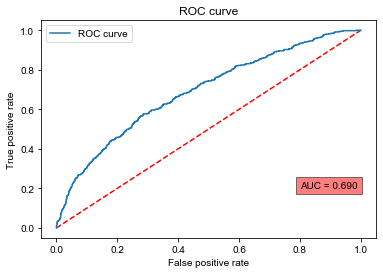

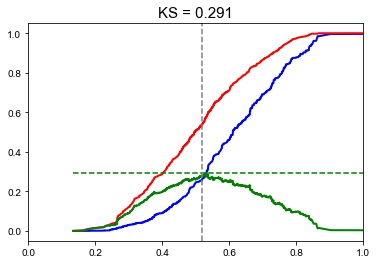

'KS = 0.291'

In [723]:
# 作图
plm = rs.PlotModel(valid_woe['target'],valid_woe['prob'])
plm.plot_roc_curve(filename=out_file)
plm.plot_ks_curve(filename=out_file)

In [696]:
########################################
# 6.评分卡构建
########################################
card = rs.ScoreCard(lr=lr,bins=bins,ml_cols=[i.replace('_woe','') for i in ml_features_new.keys()],
                    score0=550,pdo=100)
card_df = card.score_card()
joblib.dump(card_df,out_file+'card.pkl')
card_df.to_excel(out_file+'card_model.xlsx')

In [697]:
card_f = [i.replace('_woe','') for i in ml_features_new.keys()]

In [700]:
card_df.loc[card_df.index==list(ml_features.keys())[12].replace('_woe',''),:].head()

,bin,points
variable,,
td.zrf.通用分标准版_,"[-inf,570.0)",-2.62
td.zrf.通用分标准版_,"[570.0,680.0)",-0.33
td.zrf.通用分标准版_,"[680.0,inf)",2.41


In [701]:
########################################
# 7.风险决策
#######################################
dt = data_woe.loc[(data_woe['target'] != -999)&(data_woe['target'] != 2),:]

cut_off = rs.stragety_score(df=dt,step=30,score='score',label='target')
cut_off#.to_excel(path+'cut_off.xlsx')

,total,good,bad,sum_total,sum_good,sum_bad,sum_total_rate,sum_good_rate,sum_bad_rate,KS,bad_rate,good_rate,lift
"[215.0, 443.0)",1299,868,431,1299,868,431,0.099609,0.075610,0.276105,0.200495,0.331794,0.668206,2.771891
"[443.0, 500.0)",1290,1057,233,2589,1925,664,0.198528,0.167683,0.425368,0.257685,0.180620,0.819380,2.142614
"[500.0, 533.0)",1300,1105,195,3889,3030,859,0.298213,0.263937,0.550288,0.286351,0.150000,0.850000,1.845284
"[533.0, 557.0)",1307,1155,152,5196,4185,1011,0.398436,0.364547,0.647662,0.283115,0.116297,0.883703,1.625511
"[557.0, 580.0)",1278,1145,133,6474,5330,1144,0.496434,0.464286,0.732864,0.268578,0.104069,0.895931,1.476255
"[580.0, 606.0)",1341,1222,119,7815,6552,1263,0.599264,0.570732,0.809097,0.238365,0.088740,0.911260,1.350151
"[606.0, 634.0)",1310,1208,102,9125,7760,1365,0.699716,0.675958,0.874439,0.198481,0.077863,0.922137,1.249706
"[634.0, 668.0)",1297,1198,99,10422,8958,1464,0.799172,0.780314,0.937860,0.157547,0.076330,0.923670,1.173540
"[668.0, 708.0)",1290,1227,63,11712,10185,1527,0.898091,0.887195,0.978219,0.091024,0.048837,0.951163,1.089221
"[708.0, 824.0)",1328,1294,34,13040,11479,1561,0.999923,0.999913,1.000000,0.000087,0.025602,0.974398,1.000077


In [702]:
# 保存入模特征分箱详情
ml_f_bin = pd.DataFrame()
for col in ml_features_new:
    ml_f_bin = pd.concat([ml_f_bin,bins[col.replace('_woe','')]])
    
ml_f_bin = ml_f_bin.sort_values(by='total_iv',ascending=True,ignore_index=True)
ml_f_bin.to_excel(path+'ml_f_bin.xlsx',index=False)

In [730]:
len(ml_features_new)

15

In [41]:
# 评分差异校验
import joblib
card = joblib.load('./result/scorecard/card.pkl')

card = card.score_card()
card = card.reset_index(drop=False)

ml_features = list(set(card['variable']))
ml_features.remove('basepoints')
ml_features

['br.按手机号查询，近12个月申请线上现金分期的次数 / br.按身份证号查询，近3个月在非银机构-持牌消费金融机构申请机构数',
 'br.按身份证号查询，近3个月申请线上现金分期的次数 / br.按手机号查询，近3个月在非银机构-持牌网络小贷机构申请机构数',
 'br.信用风险识别-线上现金分期',
 'br.按手机号查询，近12个月申请线上现金分期的次数 / br.按身份证号查询，近6个月在非银机构申请机构数',
 'mob.credit_score',
 'br.按手机号查询，近12个月在非银机构-持牌网络小贷机构申请机构数 / br.按手机号查询，近12个月申请线上现金分期的次数',
 'YM_SCORE',
 'br.按身份证号查询，近12个月在非银机构-持牌小贷机构申请次数 / br.按手机号查询，近3个月在非银机构-持牌网络小贷机构申请机构数',
 'td.zrf.智融分2.0非银分标准版',
 'br.按手机号查询，近12个月申请线下消费分期的次数 / br.按身份证号查询，近3个月在非银机构-消费类分期机构申请次数',
 'td.zrf.通用分标准版_',
 'mob.wd_score_v2',
 'td.zrf.智融分2.0通用分标准版',
 'td.dqsh.身份证关联到的270天内非银行类金融行业下申贷事件中近90日的新增平台数',
 'mob.wd_score_v1']

In [51]:
data_req = pd.read_excel(dt_file+'data_new.xlsx')
data_req = data_req.fillna(-999)

In [57]:
s_f = []
for i in ml_features:
    if '/' in i:
        s_f = s_f+[j.strip() for j in i.split('/')]
    else:
        s_f.append(i)
        
data_req.loc[data_req['C_APP_ID']=='2424133964734507',s_f].reset_index(drop=True).to_dict(orient='index')

{0: {'br.按手机号查询，近12个月申请线上现金分期的次数': 1.0,
  'br.按身份证号查询，近3个月在非银机构-持牌消费金融机构申请机构数': 1.0,
  'br.按身份证号查询，近3个月申请线上现金分期的次数': -999.0,
  'br.按手机号查询，近3个月在非银机构-持牌网络小贷机构申请机构数': 1.0,
  'br.信用风险识别-线上现金分期': 714.0,
  'br.按身份证号查询，近6个月在非银机构申请机构数': 8.0,
  'mob.credit_score': 771,
  'br.按手机号查询，近12个月在非银机构-持牌网络小贷机构申请机构数': 2.0,
  'YM_SCORE': -999.0,
  'br.按身份证号查询，近12个月在非银机构-持牌小贷机构申请次数': 5.0,
  'td.zrf.智融分2.0非银分标准版': 746,
  'br.按手机号查询，近12个月申请线下消费分期的次数': -999.0,
  'br.按身份证号查询，近3个月在非银机构-消费类分期机构申请次数': 3.0,
  'td.zrf.通用分标准版_': 723,
  'mob.wd_score_v2': 691,
  'td.zrf.智融分2.0通用分标准版': 494,
  'td.dqsh.身份证关联到的270天内非银行类金融行业下申贷事件中近90日的新增平台数': 1.0,
  'mob.wd_score_v1': 759}}

In [56]:
ml_data = data.loc[data['C_APP_ID']=='2424133964734507'][ml_features]
ml_data.reset_index(drop=True).to_dict(orient='index')[0]

{'br.按手机号查询，近12个月申请线上现金分期的次数 / br.按身份证号查询，近3个月在非银机构-持牌消费金融机构申请机构数': 1.0,
 'br.按身份证号查询，近3个月申请线上现金分期的次数 / br.按手机号查询，近3个月在非银机构-持牌网络小贷机构申请机构数': -999.0,
 'br.信用风险识别-线上现金分期': 714.0,
 'br.按手机号查询，近12个月申请线上现金分期的次数 / br.按身份证号查询，近6个月在非银机构申请机构数': 0.125,
 'mob.credit_score': 771,
 'br.按手机号查询，近12个月在非银机构-持牌网络小贷机构申请机构数 / br.按手机号查询，近12个月申请线上现金分期的次数': 2.0,
 'YM_SCORE': 791.0,
 'br.按身份证号查询，近12个月在非银机构-持牌小贷机构申请次数 / br.按手机号查询，近3个月在非银机构-持牌网络小贷机构申请机构数': 5.0,
 'td.zrf.智融分2.0非银分标准版': 746,
 'br.按手机号查询，近12个月申请线下消费分期的次数 / br.按身份证号查询，近3个月在非银机构-消费类分期机构申请次数': -999.0,
 'td.zrf.通用分标准版_': 723,
 'mob.wd_score_v2': 691,
 'td.zrf.智融分2.0通用分标准版': 494,
 'td.dqsh.身份证关联到的270天内非银行类金融行业下申贷事件中近90日的新增平台数': 1.0,
 'mob.wd_score_v1': 759}

In [50]:
sc.scorecard_ply(dt=ml_data,card=card,only_total_score=True)['score']

8159    765.26
Name: score, dtype: float64

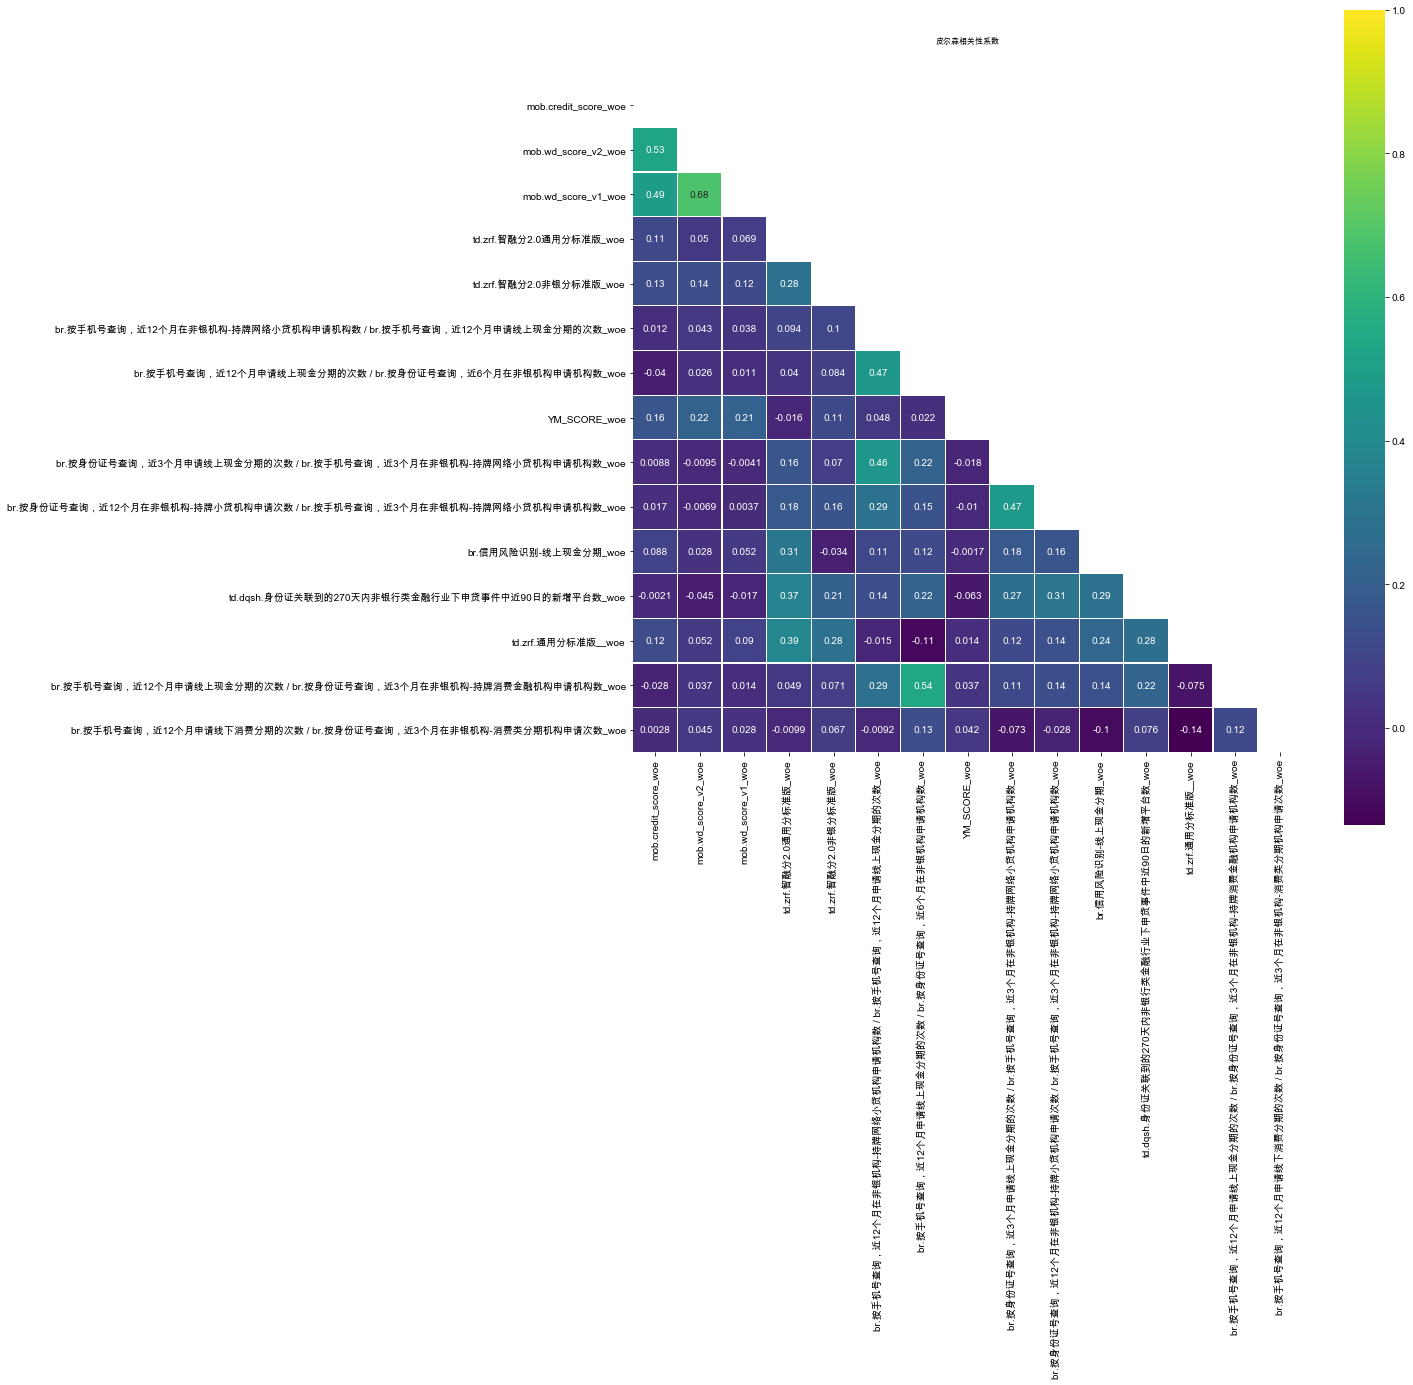

In [733]:
# 入模变量相关性
def draw_corr(df, figsize: tuple, path: str):
    """
    特征相关系数
    ------------------------
    parameter:
    data_new: dataFrame,columns must be number
    figsize: tupe,two number
    return:
            heatmap
    """
    # 相关系数分析
    colormap = plt.cm.viridis
    plt.figure(figsize=figsize)
    plt.title('皮尔森相关性系数', y=1.05, size=8)
    mask = np.zeros_like(df.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(df.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True,
                mask=mask)
    plt.savefig(path + "feature_corr.png")
    plt.show()
    plt.close()
draw_corr(data_woe[ml_features_new],figsize=(15,15),path=path)

{'mob.credit_score': 0.3116520532310414}


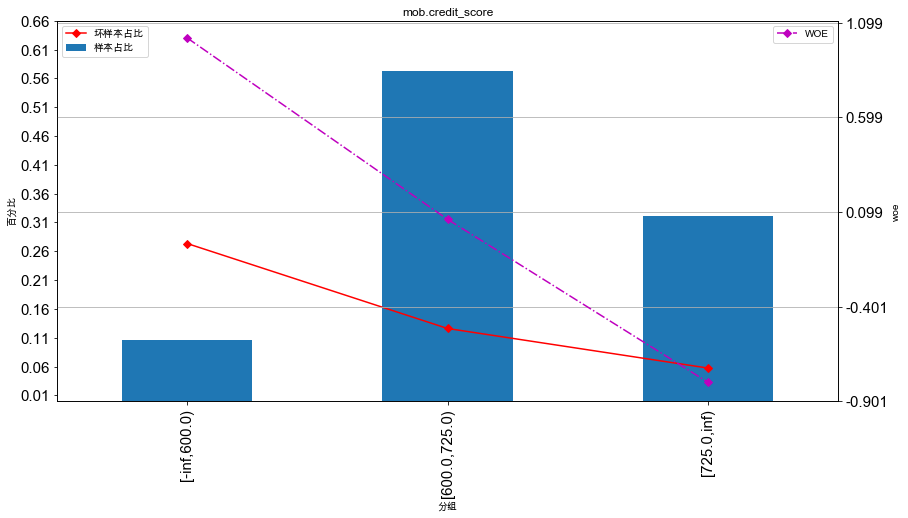

{'mob.wd_score_v2': 0.29891447437067586}


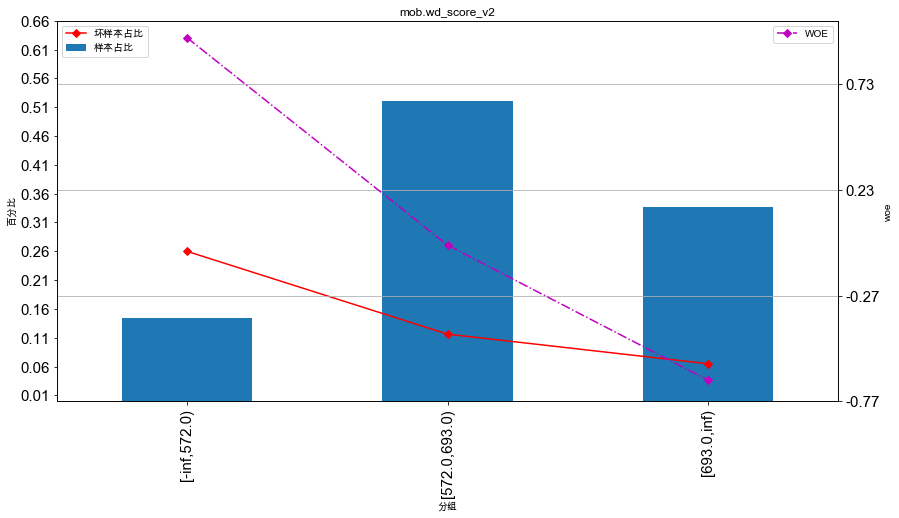

{'mob.wd_score_v1': 0.2834497551478068}


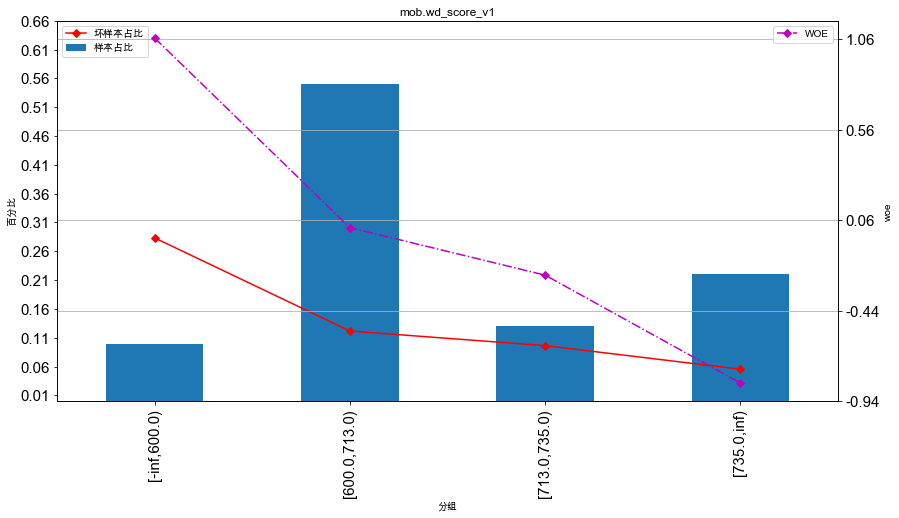

{'td.zrf.智融分2.0通用分标准版': 0.07484053667529829}


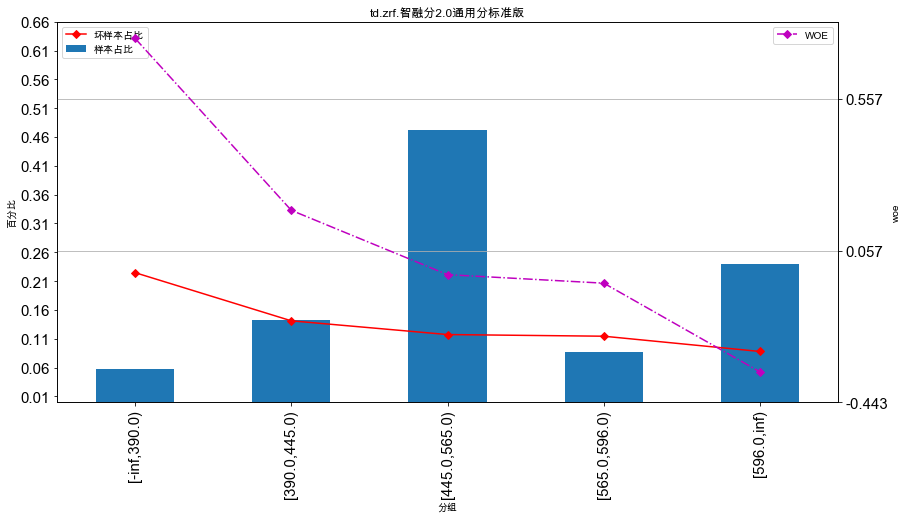

{'td.zrf.智融分2.0非银分标准版': 0.07226985484709622}


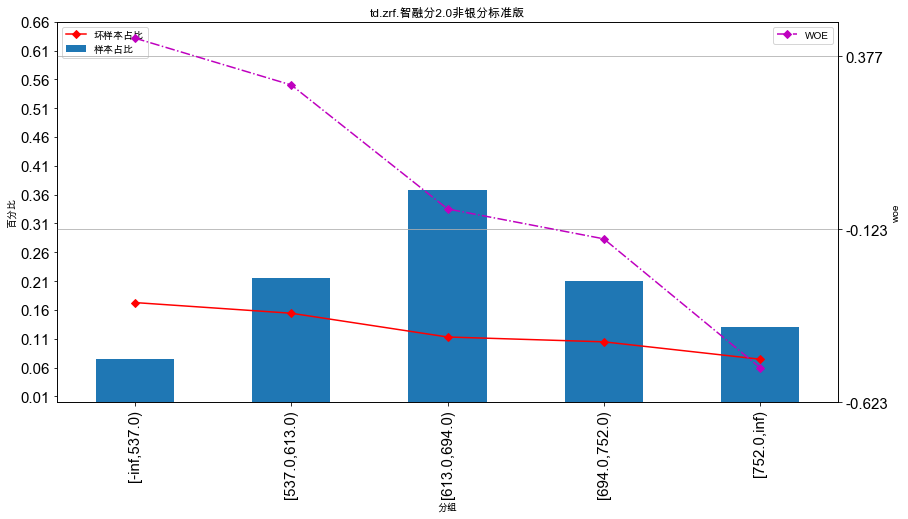

{'br.按手机号查询，近12个月在非银机构-持牌网络小贷机构申请机构数 / br.按手机号查询，近12个月申请线上现金分期的次数': 0.04914835932395261}


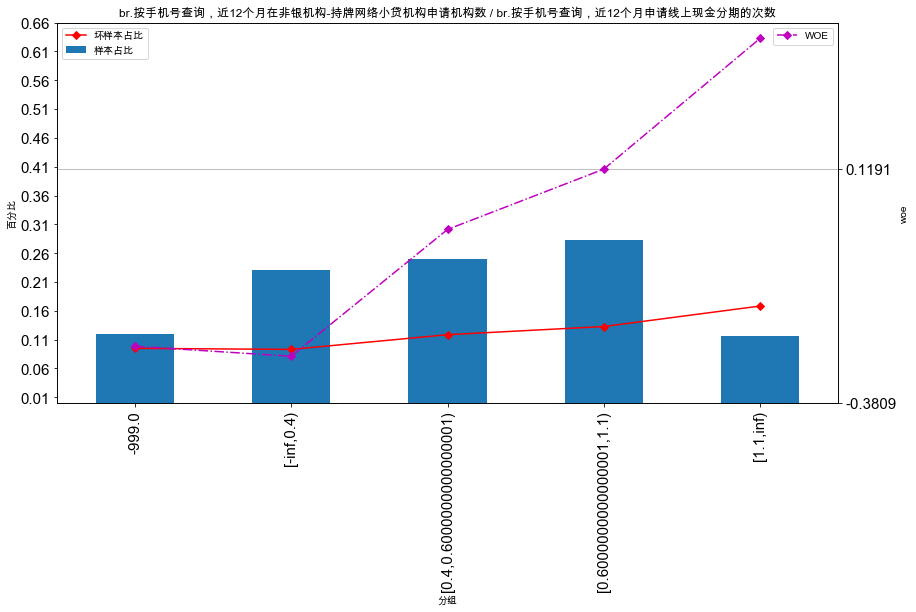

{'br.按手机号查询，近12个月申请线上现金分期的次数 / br.按身份证号查询，近6个月在非银机构申请机构数': 0.04639366709705974}


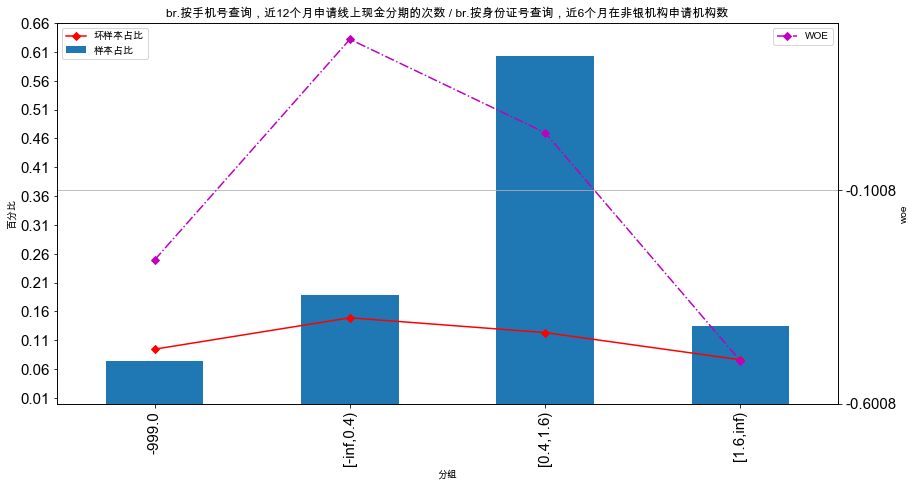

{'YM_SCORE': 0.04330420227030932}


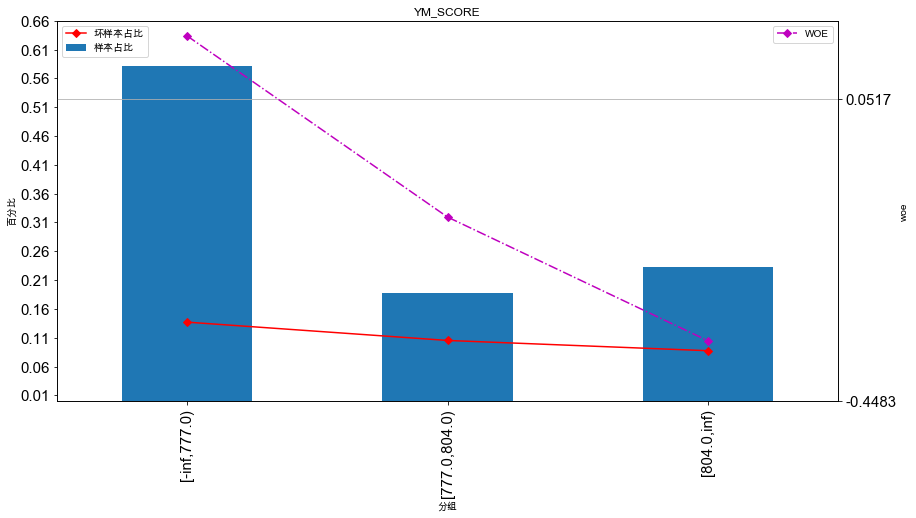

{'br.按身份证号查询，近3个月申请线上现金分期的次数 / br.按手机号查询，近3个月在非银机构-持牌网络小贷机构申请机构数': 0.03559535691528057}


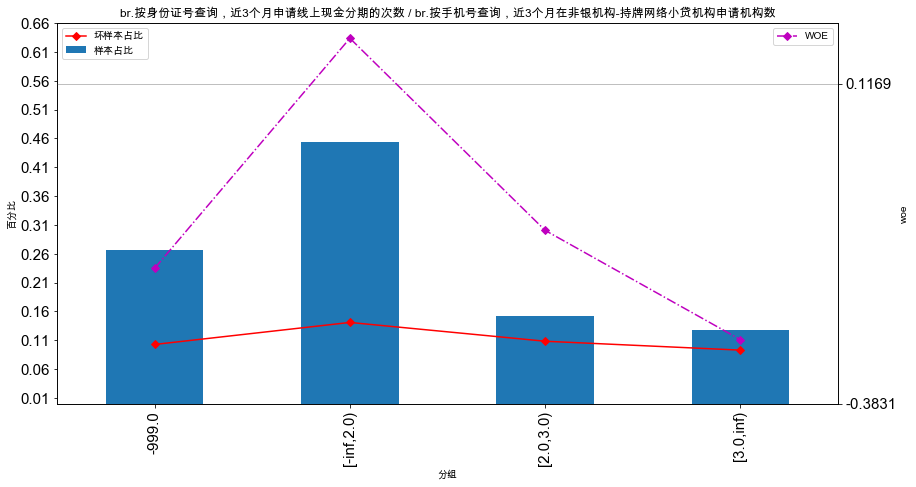

{'br.按身份证号查询，近12个月在非银机构-持牌小贷机构申请次数 / br.按手机号查询，近3个月在非银机构-持牌网络小贷机构申请机构数': 0.03327425705139257}


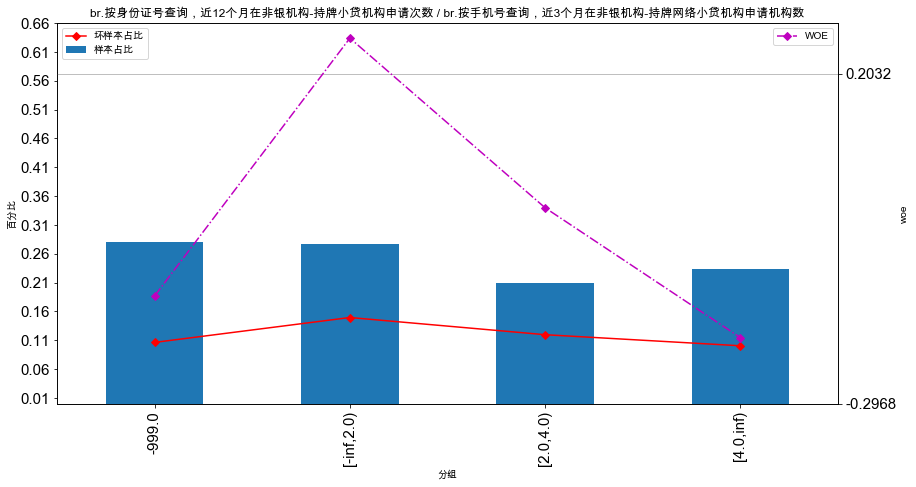

{'br.信用风险识别-线上现金分期': 0.03237190928666846}


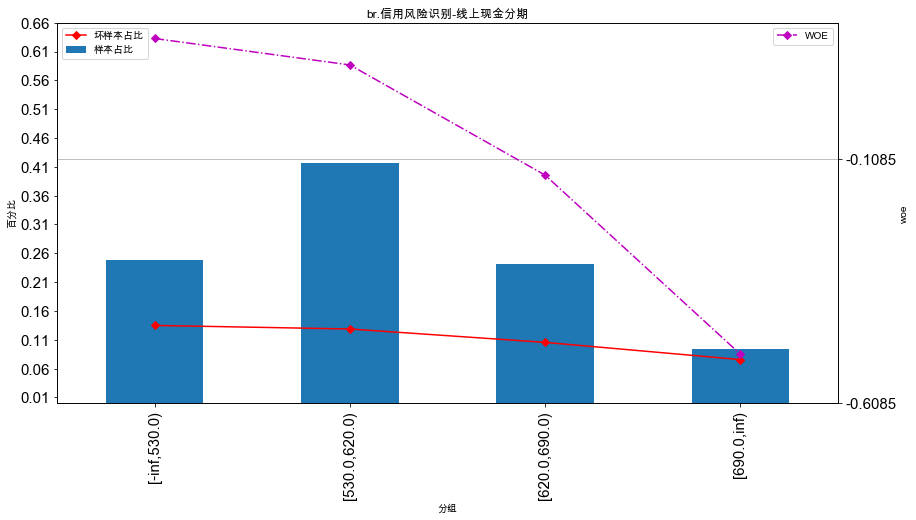

{'td.dqsh.身份证关联到的270天内非银行类金融行业下申贷事件中近90日的新增平台数': 0.03187206502720753}


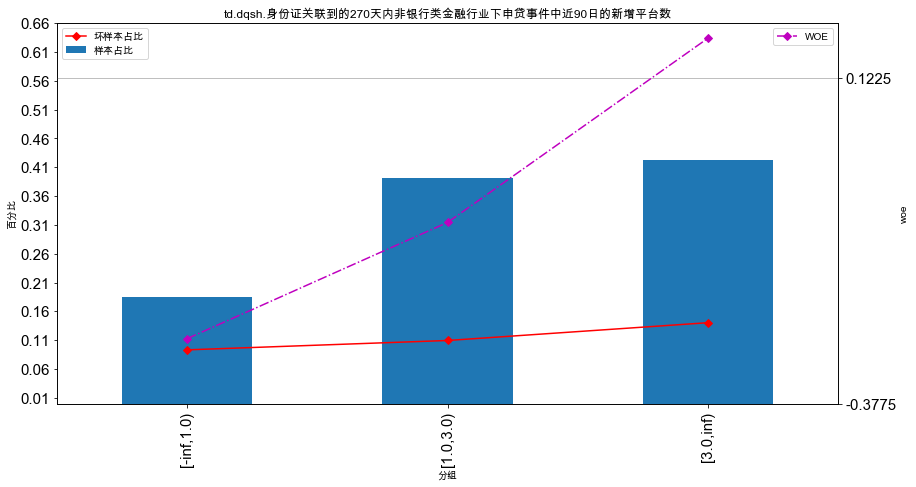

{'td.zrf.通用分标准版_': 0.030822127902957894}


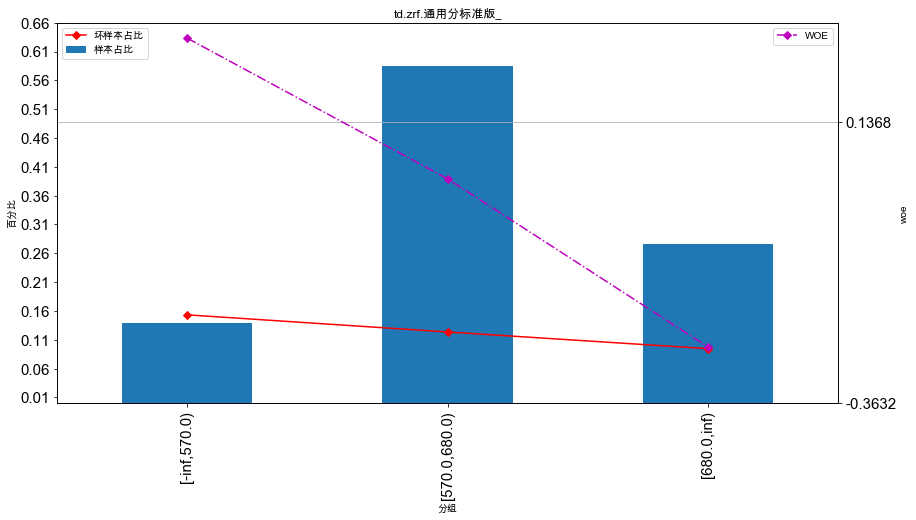

{'br.按手机号查询，近12个月申请线上现金分期的次数 / br.按身份证号查询，近3个月在非银机构-持牌消费金融机构申请机构数': 0.030627901430540824}


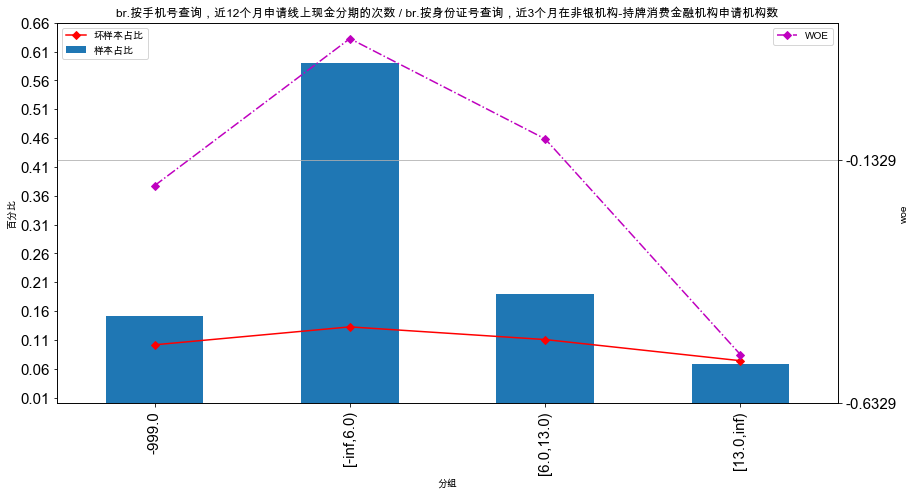

{'br.按手机号查询，近12个月申请线下消费分期的次数 / br.按身份证号查询，近3个月在非银机构-消费类分期机构申请次数': 0.030616713976658414}


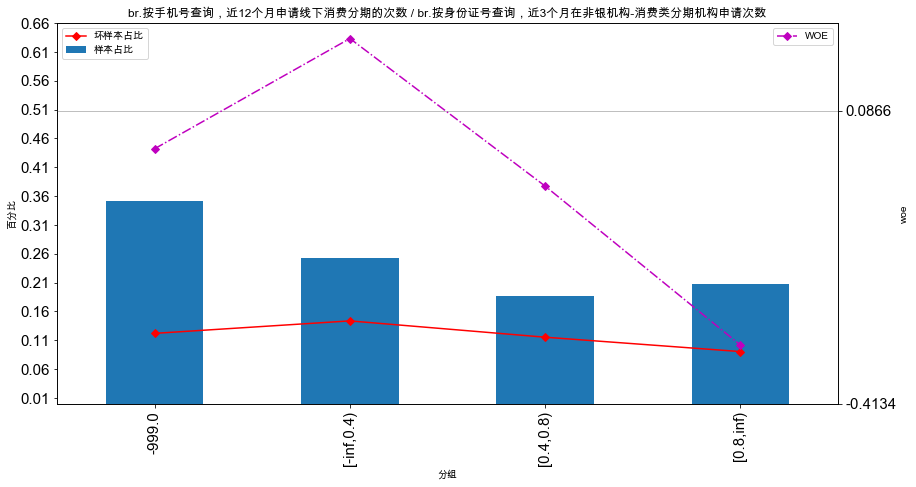

In [703]:
for col in ml_features_new:
    p_name = col.replace("_woe","")
#     p_name = '_'.join(p_name.split('/')).strip() if '/' in p_name else p_name
    plot_bins(col=p_name)